In [1]:
import cProfile
import re
import scipy

import numpy as np
import random


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numba

In [2]:
cd C:\Users\ArianStolk\Documents\GitHub\SPDC


C:\Users\ArianStolk\Documents\GitHub\SPDC


In [3]:
%run main.py
%run physics.py

In [5]:
rays_end = 5.0001
fibre_diam = 0.025
fibre_NA = 0.22

def get_results_evol(visualization,x):
    visualization.filter_results(fibre_pos=x,core_diam = fibre_diam ,Num_Ap=fibre_NA)
    Hit_Lens_True=((visualization.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))*(visualization.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))).sum(axis=1)<(3.5**2)/4
    
    dummy_new=[[[] for _ in range(5)] for _ in range(2)]
    for i,dummy_list in enumerate(visualization.dummy_surface):
        for j,attr in enumerate(dummy_list[0:-2]):

            dummy_new[i][j]=attr[Hit_Lens_True]

                
    visualization.dummy_surface=dummy_new  
   
    visualization.filter_results(fibre_pos=x,core_diam = fibre_diam ,Num_Ap=fibre_NA)
    coinc=len(visualization.coincidences[0][0])
    signal_e=(coinc)/(len(visualization.singles[1][0])+1)
    idler_e=(coinc)/(len(visualization.singles[0][0])+1)
    print("final coinc are",coinc)
    spectrum=np.histogram(np.concatenate((visualization.singles[0][2],visualization.singles[1][2])),np.linspace(600,1100,400))
    return [coinc,signal_e,idler_e,spectrum]

def focus_setup(y,sbeg,send,ibeg,iend,z_beg,z_end,offset=0):
    returnlist=[]
    pos=offset+y

    scale=((pos-z_beg)/(z_end-z_beg))
#     scale=((pos-z_beg)/(z_end-z_beg))[0]
    
    signal=sbeg+(send-sbeg)*scale
    idler=ibeg+(iend-ibeg)*scale

    spot_sig=np.histogram2d(signal[:,0],signal[:,1],[np.linspace(-0.4,-0.0,100),np.linspace(-0.1,0.1,50)])[0]
    spot_idl=np.histogram2d(idler[:,0],idler[:,1],[np.linspace(-0.4,-0.0,100),np.linspace(-0.1,0.1,50)])[0]
    
    comb_spot=(spot_sig+spot_idl)
    maxindex=np.unravel_index(np.argmax(comb_spot),(50,100))
    
    return [np.max(comb_spot),np.linspace(-0.4,-0.0,100)[maxindex[1]],np.linspace(-0.1,0.1,50)[maxindex[0]]]

In [6]:
Optimize = True


pumps = [[x*0.001,x*0.001] for x in range(5,50,5)] + [[x*0.001,x*0.001] for x in range(75,300,25)]
# pumps =[[x*0.001,x*0.001] for x in range(75,300,25)]

pump_M2_list=[[1,1]]*len(pumps)
pump_focus_list=[[2.5,2.5]]*len(pumps)

xpos=np.linspace(1,6,20)

lensd_photons_1=[[[] for x in range(len(xpos))]for y in pumps]
lensd_fibre_1=[[[] for x in range(len(xpos))]for y in pumps]

for k in range(1):
    pumpcurv=True
    walkoff=True
    for i,pump in enumerate(pumps):
        pump=np.array(pump)
        print(pump)
        pump_focus=np.array(pump_focus_list[i])
        pump_M2 = pump_M2_list[i]
#     for i,pump in enumerate([[0.5,0.5]]):
        for j,holes in enumerate(xpos):
#         for j,holes in enumerate([4,5]):
            Crystal1=Crystal(name = 'BBO1',material = 'BBO',position = [0,0,2.5],thickness = 5,orientation="up",cutangle=28.76*np.pi/180)
            lenspos=25*holes
    #         print(lenspos)
            ACH=Lens.asphere_r(position = [0,0,lenspos],centre=[-0.18,0,0],f=250)
            Csetup=ExpSetup(Crystal1,ACH)
            sim2=Simulation(rays=[0],setup=Csetup)
            sim2.run(Ntot=3000000,nr_crystals=1,gen_SPDC = True,pumpray=Ray(position=[0,0,0],angles=[0,0],wavelength=405,polarization="H"),pump_waist=pump,pump_focus=pump_focus,pump_M2=pump_M2,walkoff=walkoff,pumpcurv=pumpcurv)
            print(len(sim2.complete_results[0][0]))
            vis2=Visualization(simulation=sim2)
#             plt.figure()
#             plt.hist(90/np.pi*((vis2.simulation.start_list[0][1]).T[0]+(vis2.simulation.start_list[1][1]).T[0]),alpha=0.5)
#             plt.hist(90/np.pi*((vis2.simulation.start_list[0][1]).T[1]+(vis2.simulation.start_list[1][1]).T[1]),alpha=0.5)
#             plt.show()
    #         vis2.showpos_single(pos=5.001)
    #         vis2.SPDC_list=SPDC_list
            Hit_Lens_True=((vis2.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))*(vis2.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))).sum(axis=1)<(3.5**2)/4

            send=np.float32(vis2.complete_results[0][0][...,-1][...,0:2])[Hit_Lens_True]
            sbeg=np.float32(vis2.complete_results[0][0][...,-2][...,0:2])[Hit_Lens_True]

            iend=np.float32(vis2.complete_results[1][0][...,-1][...,0:2])[Hit_Lens_True]
            ibeg=np.float32(vis2.complete_results[1][0][...,-2][...,0:2])[Hit_Lens_True]

            z_beg_val=np.float32(vis2.complete_results[0][0][...,-2][0][...,2])
            z_end_val=np.float32(vis2.complete_results[0][0][...,-1][0][...,2])


            [sbeg,send,ibeg,iend]=Visualization.select_NA_TRUE(sbeg,send,ibeg,iend,z_beg_val,z_end_val,core_diam=0.025,Num_Ap=0.22)
            
            
#             plt.plot(np.linspace(8,11,500),[focus_setup(x,sbeg,send,ibeg,iend,z_beg_val,z_end_val,offset=lenspos)[0] for x in np.linspace(8,11,500)])
#             plt.title("pump is {} and lensd is {}".format(pump,lenspos))
#             plt.show()

#             [(vis2.showpos_single(pos = x+lenspos),print(focus_setup(x+lenspos,sbeg,send,ibeg,iend,z_beg_val,z_end_val))) for x in np.linspace(15,21,25)]

    #         print(np.min([vis2.showpos_single(pos=x+lenspos) for x in np.linspace(0,100,100)]))
            
            scanlist=np.array([focus_setup(x,sbeg,send,ibeg,iend,z_beg_val,z_end_val,lenspos) for x in np.linspace(8,11,500)]).T
            result_for_foc=[np.max(scanlist[0]),np.linspace(8,11,500)[np.argmax(scanlist[0])],scanlist[1][np.argmax(scanlist[0])],scanlist[2][np.argmax(scanlist[0])]]
            print(result_for_foc)
#             search_pos=[result_for_foc[2],result_for_foc[3],result_for_foc[1]+lenspos]
            search_pos=[-0.168,0,result_for_foc[1]+lenspos]
            if Optimize:
                dx=0.1
                dy=0.01
                dz=0.5
                res=np.empty((20,20,100))
                scale=1
                scale_evol=0.75
                coinc_start= 0
                coincs= 0
                been_0=False
                while dz>0.005 and dz<10 :

                        print(dx,dy,dz,search_pos)

                        x_range=np.linspace(search_pos[0]-dx,search_pos[0]+dx,20,dtype=np.float32)
                        y_range=np.linspace(search_pos[1]-dy,search_pos[1]+dy,20,dtype=np.float32)
                        z_range=np.linspace(search_pos[2]-dz,search_pos[2]+dz,100,dtype=np.float32)

                        res=d_coinc(sbeg, send ,ibeg,iend,x_range,y_range,(z_range-z_beg_val)/(z_end_val-z_beg_val))
                        coincs=np.max(res)
                        maxindex=np.unravel_index(np.argmax(res),res.shape)


                        if coincs < 2:
                            dx *= 1.
                            dy *= 1.
                            dz *= 1.1
                            search_pos[2]+=0.01
                            been_0 =True
#                             if not coincs == 0: 
#                                 search_pos[2] = z_range[maxindex[2]]
                            dx = max(0.2,dx)
                            dy = max(0.05,dy)


                        else:
                            if been_0:
                                dx=0.1
                                dy=0.02
                                dz=0.1
                                been_0 = False

                            scale *=scale_evol 
                            dx *= scale*(0.66+2*((abs(maxindex[0]-10))/20))
                            dy *= scale*(0.66+2*((abs(maxindex[1]-10))/20))
                            dz *= scale*(0.66+2*((abs(maxindex[2]-50))/100))

    #                         dx *= 2/100
    #                         dy *= 2/60
    #                         dz *= 2/100

                            search_pos = [x_range[maxindex[0]],y_range[maxindex[1]],z_range[maxindex[2]]]
                        diff=abs(coinc_start-coincs)
                        coinc_start=coincs
                        print("coincidences are",coincs,maxindex)

    #         vis2.showpos_single(pos=search_pos[-1])
            print(search_pos)
            lensd_fibre_1[i][j]=search_pos
#             del sim2.start_list
#             sim2.interpol_pos = 0
# #             print(hasattr(sim2,'start_list'))
#             sim2.run(Ntot=30000000,nr_crystals=1,gen_SPDC = True,pumpray=Ray(position=[0,0,0],angles=[0,0],wavelength=405,polarization="H"),pump_waist=pump,pump_focus=pump_focus,pump_M2=pump_M2,walkoff=walkoff,pumpcurv=pumpcurv)
#             vis_result=Visualization(simulation=sim2)

    #         vis_result.showpos_single(pos=search_pos[-1])


            lensd_photons_1[i][j]+=get_results_evol(vis2,search_pos)
    print("doing iteration {}".format(k+1))



            
        



[ 0.005  0.005]
5795
[6.0, 9.8877755511022052, -0.29494949494949496, -0.018367346938775508]
0.1 0.01 0.5 [-0.168, 0, 34.887775551102209]
coincidences are 18.0 (7, 4, 97)
0.072 0.00945 0.6 [-0.19431579, -0.0057894737, 35.367573]
coincidences are 24.0 (10, 6, 99)
0.02673 0.0056345625 0.5535 [-0.19052632, -0.0092710527, 35.967571]
coincidences are 32.0 (7, 15, 99)
0.01082565 0.00275741402344 0.3829528125 [-0.19756053, -0.0060089375, 36.521072]
coincidences are 44.0 (16, 0, 98)
0.00431588218359 0.00144828863122 0.196293234595 [-0.19015351, -0.0087663513, 36.89629]
coincidences are 54.0 (7, 7, 99)
0.00098321190995 0.000329938253799 0.0763933396979 [-0.19128926, -0.0091474801, 37.092583]
coincidences are 56.0 (18, 11, 99)
0.000255486270565 4.46286597009e-05 0.022298052053 [-0.19040954, -0.0090953847, 37.168976]
coincidences are 57.0 (10, 0, 99)
[-0.1903961, -0.0091400137, 37.191273]
final coinc are 7
5880
[11.0, 10.993987975951903, -0.27474747474747474, -0.002040816326530609]
0.1 0.01 0.5 [-

5864
[119.0, 9.2805611222444888, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 113.22792954329712]
coincidences are 226.0 (8, 5, 58)
0.0645 0.0087 0.3075 [-0.18378948, -0.0047368421, 113.31379]
coincidences are 226.0 (9, 12, 49)
0.02757375 0.004208625 0.11761875 [-0.18718421, -0.0024473683, 113.31068]
coincidences are 226.0 (10, 6, 50)
0.00767756601563 0.00188204449219 0.0327494707031 [-0.18573296, -0.0039979145, 113.31187]
coincidences are 226.0 (8, 15, 46)
0.00208913769003 0.000690769142523 0.00766798153885 [-0.18694521, -0.0029083097, 113.30956]
coincidences are 226.0 (8, 16, 56)
[-0.18727508, -0.0024356782, 113.31056]
final coinc are 116
5834
[121.0, 9.2384769539078153, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 119.76479274338149]
coincidences are 183.0 (8, 5, 59)
0.0645 0.0087 0.315 [-0.18378948, -0.0047368421, 119.86076]
coincidences are 183.0 (9, 11, 48)
0.02757375 0.00371925 0.12403125 [-0.18718421, -0.0033631579, 119.85121]
coi

coincidences are 2711.0 (9, 14, 42)
0.00160329171561 0.000423825062476 0.00854091309814 [-0.17948535, -0.00010409762, 55.381306]
coincidences are 2715.0 (7, 16, 49)
[-0.17990726, 0.00018588796, 55.381218]
final coinc are 1258
7961
[550.0, 10.230460921843687, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 61.546250395527892]
coincidences are 2559.0 (8, 9, 57)
0.0645 0.0057 0.3 [-0.18378948, -0.00052631577, 61.622009]
coincidences are 2609.0 (10, 9, 50)
0.023945625 0.00243675 0.111375 [-0.18039474, -0.00082631578, 61.625038]
coincidences are 2606.0 (10, 12, 50)
0.00666735996094 0.000884083359375 0.0310109765625 [-0.17913444, -0.00018506579, 61.626163]
coincidences are 2614.0 (7, 10, 43)
0.00202521058813 0.000184621470282 0.00784965344238 [-0.18088901, -0.00013853508, 61.622093]
coincidences are 2615.0 (10, 0, 48)
[-0.18078242, -0.00032315654, 61.621857]
final coinc are 1315
8032
[587.0, 10.008016032064129, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0

coincidences are 870.0 (8, 13, 42)
[-0.18846168, -9.502958e-05, 132.92804]
final coinc are 378
8032
[655.0, 9.130260521042084, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 139.39341841577894]
coincidences are 753.0 (8, 5, 56)
0.0645 0.0087 0.2925 [-0.18378948, -0.0047368421, 139.45908]
coincidences are 753.0 (9, 10, 50)
0.02757375 0.003229875 0.108590625 [-0.18718421, -0.0042789476, 139.46204]
coincidences are 753.0 (9, 10, 51)
0.00884083359375 0.000899318320313 0.0311519355469 [-0.18863547, -0.0041089542, 139.46533]
coincidences are 753.0 (9, 15, 49)
0.00212594420325 0.000330077927252 0.00670253363251 [-0.18910077, -0.0035882962, 139.46501]
coincidences are 753.0 (9, 17, 51)
[-0.18921266, -0.0033277085, 139.46521]
final coinc are 270
7970
[555.0, 9.1122244488977948, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 145.95432971205568]
coincidences are 634.0 (8, 3, 56)
0.0645 0.0102 0.2925 [-0.18378948, -0.0068421052, 146.01999]
coincidences a

coincidences are 3700.0 (9, 5, 49)
0.00184621470282 0.000625602242285 0.0072181131427 [-0.18205912, 0.00031947042, 80.827606]
coincidences are 3701.0 (10, 13, 43)
[-0.18196195, 0.00054995547, 80.82666]
final coinc are 2030
9555
[1041.0, 9.5691382765531063, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 87.200717223921529]
coincidences are 3250.0 (8, 10, 59)
0.0645 0.00495 0.315 [-0.18378948, 0.00052631577, 87.296677]
coincidences are 3261.0 (10, 10, 49)
0.023945625 0.0018376875 0.1204875 [-0.18039474, 0.00078684208, 87.293495]
coincidences are 3263.0 (9, 12, 52)
0.00767756601563 0.000666735996094 0.0355814648438 [-0.18165503, 0.001270444, 87.299583]
coincidences are 3262.0 (9, 4, 49)
0.00184621470282 0.000265808889693 0.00765557454529 [-0.18205912, 0.00088443898, 87.299225]
coincidences are 3264.0 (11, 15, 57)
[-0.18176761, 0.0010383284, 87.300385]
final coinc are 1831
9759
[1243.0, 9.4789579158316641, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.1

coincidences are 1378.0 (9, 13, 50)
[-0.18567181, -0.0019490845, 159.10153]
final coinc are 1163
[ 0.02  0.02]
10871
[47.0, 10.861723446893787, -0.10909090909090913, 0.002040816326530609]
0.1 0.01 0.5 [-0.168, 0, 35.861723446893791]
coincidences are 503.0 (7, 9, 97)
0.072 0.0057 0.6 [-0.19431579, -0.00052631577, 36.341522]
coincidences are 572.0 (9, 12, 99)
0.03078 0.002757375 0.5535 [-0.19810526, 0.00097368425, 36.941521]
coincidences are 732.0 (7, 9, 99)
0.0124659 0.000884083359375 0.3829528125 [-0.20620526, 0.00082855922, 37.495022]
coincidences are 1064.0 (1, 9, 99)
0.00615309032812 0.000212594420325 0.198716607861 [-0.21735896, 0.00078202854, 37.877975]
coincidences are 1388.0 (0, 0, 99)
0.00242386091461 8.37464231158e-05 0.0773364673485 [-0.22351205, 0.00056943414, 38.076691]
coincidences are 1560.0 (1, 6, 99)
0.000672976461555 1.57993679196e-05 0.0225733366463 [-0.22568077, 0.00053858018, 38.154026]
coincidences are 1621.0 (3, 12, 99)
[-0.22614123, 0.00054273789, 38.176598]
fina

coincidences are 3773.0 (8, 9, 45)
0.00868777207031 0.000857030625 0.0388206738281 [-0.18417563, -0.000917, 106.8055]
coincidences are 3773.0 (9, 9, 50)
0.00208913769003 0.000206089083105 0.00810684852676 [-0.18463288, -0.00096210686, 106.80589]
coincidences are 3773.0 (10, 1, 53)
[-0.18452293, -0.0011465023, 106.80646]
final coinc are 2392
10672
[2009.0, 9.2865731462925858, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 113.23394156734521]
coincidences are 3380.0 (8, 6, 58)
0.0645 0.00795 0.3075 [-0.18378948, -0.0036842106, 113.3198]
coincidences are 3381.0 (10, 19, 52)
0.023945625 0.006976125 0.121078125 [-0.18039474, 0.0042657894, 113.33533]
coincidences are 3381.0 (9, 8, 47)
0.00767756601563 0.00253102535156 0.0367774804687 [-0.18165503, 0.003164296, 113.32922]
coincidences are 3381.0 (7, 11, 52)
0.00233206067725 0.000608632502509 0.0081456372757 [-0.18367545, 0.0035639317, 113.33107]
coincidences are 3381.0 (8, 9, 51)
[-0.18404368, 0.0035318984, 113.33131]
fi

coincidences are 5201.0 (8, 11, 45)
0.00868777207031 0.000857030625 0.0377115117188 [-0.18417563, -0.00035426317, 55.328342]
coincidences are 5197.0 (10, 13, 63)
0.00181425115187 0.000260323052344 0.0109775853644 [-0.18371837, -3.8515049e-05, 55.338627]
coincidences are 5203.0 (7, 3, 13)
[-0.1841958, -0.00021663083, 55.330532]
final coinc are 2055
11399
[586.0, 10.200400801603205, -0.10101010101010105, -0.002040816326530609]
0.1 0.01 0.5 [-0.168, 0, 61.516190275287414]
coincidences are 6185.0 (8, 10, 56)
0.0645 0.00495 0.2925 [-0.18378948, 0.00052631577, 61.581848]
coincidences are 6210.0 (10, 9, 49)
0.023945625 0.002116125 0.11188125 [-0.18039474, 0.00026578945, 61.578892]
coincidences are 6238.0 (9, 5, 52)
0.00767756601563 0.00103557867188 0.0330399316406 [-0.18165503, -0.00073658553, 61.584541]
coincidences are 6241.0 (10, 14, 41)
0.00160329171561 0.000347323377997 0.00878139433136 [-0.18125094, -0.00024604826, 61.578869]
coincidences are 6242.0 (6, 16, 80)
[-0.18184163, -8.4059538e

coincidences are 3503.0 (9, 9, 49)
0.00208913769003 0.000365469844977 0.00712437141357 [-0.18463288, -0.0010964314, 132.90288]
coincidences are 3503.0 (9, 9, 50)
[-0.18474284, -0.0011156667, 132.90295]
final coinc are 3150
11146
[3696.0, 9.130260521042084, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 139.39341841577894]
coincidences are 3398.0 (8, 5, 57)
0.0645 0.0087 0.3 [-0.18378948, -0.0047368421, 139.46918]
coincidences are 3398.0 (9, 11, 51)
0.02757375 0.00371925 0.11475 [-0.18718421, -0.0033631579, 139.47827]
coincidences are 3398.0 (10, 5, 46)
0.00767756601563 0.00182010796875 0.035823515625 [-0.18573296, -0.0051249079, 139.47015]
coincidences are 3398.0 (8, 15, 56)
0.00208913769003 0.000668036502905 0.00884113170776 [-0.18694521, -0.0040711612, 139.47485]
coincidences are 3398.0 (7, 18, 60)
[-0.18749499, -0.0034734444, 139.47673]
final coinc are 1638
11390
[3566.0, 9.1002004008016026, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 1

coincidences are 6167.0 (9, 5, 53)
0.00767756601563 0.000899318320313 0.0339839296875 [-0.18165503, -8.3641469e-05, 80.824654]
coincidences are 6169.0 (9, 13, 56)
0.00184621470282 0.000273167939795 0.00838712764709 [-0.18205912, 0.00024768634, 80.829117]
coincidences are 6169.0 (9, 11, 49)
[-0.18215629, 0.00029081813, 80.829033]
final coinc are 2619
11271
[1215.0, 9.5871743486973955, -0.32323232323232326, 0.010204081632653073]
0.1 0.01 0.5 [-0.168, 0, 87.218753296065813]
coincidences are 5816.0 (8, 9, 57)
0.0645 0.0057 0.3 [-0.18378948, -0.00052631577, 87.29451]
coincidences are 5832.0 (10, 9, 50)
0.023945625 0.00243675 0.111375 [-0.18039474, -0.00082631578, 87.297539]
coincidences are 5835.0 (9, 8, 52)
0.00767756601563 0.000884083359375 0.0328904296875 [-0.18165503, -0.0012110658, 87.303162]
coincidences are 5835.0 (9, 9, 52)
0.00184621470282 0.000212594420325 0.00728471626282 [-0.18205912, -0.0012575965, 87.304825]
coincidences are 5836.0 (12, 15, 38)
[-0.18157327, -0.0011345155, 87.

coincidences are 3043.0 (9, 15, 51)
0.00212594420325 0.000623355107794 0.00667220542603 [-0.18910077, -0.0031935119, 159.13298]
coincidences are 3043.0 (9, 11, 51)
[-0.18921266, -0.0030950874, 159.13318]
final coinc are 1043
[ 0.035  0.035]
11264
[70.0, 9.3887775551102202, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 34.388777555110224]
coincidences are 735.0 (8, 9, 55)
0.0645 0.0057 0.285 [-0.18378948, -0.00052631577, 34.444332]
coincidences are 774.0 (10, 11, 31)
0.023945625 0.00243675 0.166725 [-0.18039474, 0.00037368425, 34.337818]
coincidences are 770.0 (9, 8, 48)
0.00767756601563 0.000884083359375 0.0492359765625 [-0.18165503, -1.1065752e-05, 34.332767]
coincidences are 775.0 (11, 11, 56)
0.00184621470282 0.000212594420325 0.0121512851532 [-0.18044278, 0.00012852636, 34.339233]
coincidences are 776.0 (10, 9, 74)
[-0.18034561, 0.00011733718, 34.345249]
final coinc are 253
11217
[76.0, 9.7194388777555112, -0.31515151515151518, 0.0061224489795918408]
0.1 0.01

coincidences are 4799.0 (9, 11, 49)
0.00208913769003 0.00043767908811 0.00809303594788 [-0.18463288, -0.00078568031, 106.8057]
coincidences are 4799.0 (9, 9, 48)
[-0.18474284, -0.00080871605, 106.80546]
final coinc are 2833
11374
[2315.0, 9.2865731462925858, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 113.23394156734521]
coincidences are 4560.0 (8, 9, 59)
0.0645 0.0057 0.315 [-0.18378948, -0.00052631577, 113.3299]
coincidences are 4560.0 (10, 11, 48)
0.023945625 0.00243675 0.12403125 [-0.18039474, 0.00037368425, 113.32036]
coincidences are 4560.0 (8, 5, 54)
0.00868777207031 0.00119248453125 0.0387210058594 [-0.18417563, -0.00078056578, 113.33163]
coincidences are 4560.0 (8, 9, 55)
0.0023640242282 0.000286755264624 0.00931119187775 [-0.18554738, -0.00084332813, 113.33594]
coincidences are 4560.0 (9, 4, 53)
[-0.18567181, -0.0010093444, 113.33659]
final coinc are 2395
11318
[2729.0, 9.2384769539078153, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.1

coincidences are 4886.0 (11, 6, 44)
0.00884083359375 0.000946304648438 0.0330399316406 [-0.18283047, 0.00052826968, 55.326023]
coincidences are 4894.0 (9, 13, 56)
0.00212594420325 0.000287440036963 0.00815415187912 [-0.18329577, 0.00087690825, 55.33036]
coincidences are 4896.0 (10, 11, 44)
[-0.18318388, 0.00092229352, 55.329453]
final coinc are 1826
11109
[375.0, 10.254509018036073, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 61.57029849172028]
coincidences are 5720.0 (8, 9, 51)
0.0645 0.0057 0.255 [-0.18378948, -0.00052631577, 61.585449]
coincidences are 5728.0 (10, 10, 50)
0.023945625 0.002116125 0.09466875 [-0.18039474, -0.00022631577, 61.588024]
coincidences are 5746.0 (9, 9, 54)
0.00767756601563 0.000678482578125 0.0295544003906 [-0.18165503, -0.00033769076, 61.59663]
coincidences are 5754.0 (8, 9, 30)
0.00208913769003 0.000163153857458 0.00991226881851 [-0.18286729, -0.00037340037, 61.584988]
coincidences are 5752.0 (10, 7, 38)
[-0.18275733, -0.0004163355

coincidences are 3708.0 (9, 11, 53)
0.00212594420325 0.000548749161475 0.00727876955566 [-0.18910077, 0.0011230491, 132.9328]
coincidences are 3708.0 (8, 19, 58)
[-0.18943645, 0.0016717982, 132.93405]
final coinc are 1248
11215
[4135.0, 9.130260521042084, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 139.39341841577894]
coincidences are 3647.0 (8, 1, 58)
0.0645 0.0117 0.3075 [-0.18378948, -0.0089473687, 139.47928]
coincidences are 3647.0 (9, 11, 49)
0.02757375 0.00500175 0.11761875 [-0.18718421, -0.0071000005, 139.47617]
coincidences are 3647.0 (9, 13, 51)
0.00884083359375 0.00202570875 0.0337418789063 [-0.18863547, -0.0052572507, 139.47974]
coincidences are 3647.0 (9, 12, 50)
0.00212594420325 0.000551214341895 0.00704625330597 [-0.18910077, -0.0047241696, 139.48007]
coincidences are 3647.0 (9, 12, 52)
[-0.18921266, -0.0045791133, 139.48042]
final coinc are 879
11290
[4197.0, 9.1002004008016026, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0,

coincidences are 5867.0 (9, 8, 47)
0.00767756601563 0.00123306363281 0.0339839296875 [-0.18165503, -0.0010576776, 80.816895]
coincidences are 5871.0 (9, 10, 51)
0.00184621470282 0.000257498366446 0.00731185487183 [-0.18205912, -0.0009927795, 80.817924]
coincidences are 5873.0 (9, 15, 50)
[-0.18215629, -0.00084370148, 80.818001]
final coinc are 2843
11130
[995.0, 9.5751503006012015, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 87.206729247969633]
coincidences are 5600.0 (8, 10, 58)
0.0645 0.00495 0.3075 [-0.18378948, 0.00052631577, 87.292587]
coincidences are 5612.0 (10, 9, 50)
0.023945625 0.002116125 0.114159375 [-0.18039474, 0.00026578945, 87.295692]
coincidences are 5618.0 (9, 8, 50)
0.00767756601563 0.000767756601563 0.0317862509766 [-0.18165503, -6.8335547e-05, 87.296844]
coincidences are 5619.0 (9, 0, 50)
0.00184621470282 0.000403252158774 0.00663786319221 [-0.18205912, -0.00083609216, 87.297165]
coincidences are 5620.0 (9, 18, 57)
[-0.18215629, -0.00047528

coincidences are 3151.0 (8, 18, 55)
0.00240567370367 0.00124416475462 0.00745717077026 [-0.19003139, -0.0014610634, 159.13548]
coincidences are 3151.0 (8, 17, 57)
[-0.19041124, -0.00047882806, 159.13661]
final coinc are 785
[ 0.075  0.075]
10924
[159.0, 9.0881763527054105, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 34.08817635270541]
coincidences are 860.0 (8, 9, 67)
0.0645 0.0057 0.375 [-0.18378948, -0.00052631577, 34.264942]
coincidences are 898.0 (10, 10, 27)
0.023945625 0.002116125 0.23625 [-0.18039474, -0.00022631577, 34.094486]
coincidences are 897.0 (10, 9, 46)
0.00666735996094 0.000678482578125 0.073754296875 [-0.17913444, -0.00033769076, 34.077782]
coincidences are 902.0 (8, 9, 51)
0.00181425115187 0.000163153857458 0.015868697937 [-0.18018718, -0.00037340037, 34.080017]
coincidences are 903.0 (11, 18, 18)
[-0.17990072, -0.00022742061, 34.06992]
final coinc are 436
11202
[169.0, 9.1062124248496996, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 

coincidences are 4681.0 (8, 7, 59)
0.0645 0.0072 0.315 [-0.18378948, -0.0026315791, 106.80506]
coincidences are 4681.0 (10, 11, 48)
0.023945625 0.003078 0.12403125 [-0.18039474, -0.001494737, 106.79552]
coincidences are 4681.0 (8, 4, 52)
0.00868777207031 0.001636149375 0.0366279785156 [-0.18417563, -0.0032767369, 106.80178]
coincidences are 4681.0 (8, 15, 44)
0.0023640242282 0.000600517950293 0.00903967063522 [-0.18554738, -0.0023294925, 106.79771]
coincidences are 4681.0 (8, 13, 49)
[-0.18592066, -0.0021082491, 106.79762]
final coinc are 2563
11141
[1998.0, 9.2865731462925858, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 113.23394156734521]
coincidences are 4393.0 (8, 6, 58)
0.0645 0.00795 0.3075 [-0.18378948, -0.0036842106, 113.3198]
coincidences are 4394.0 (10, 11, 47)
0.023945625 0.003398625 0.1245375 [-0.18039474, -0.0024289475, 113.30427]
coincidences are 4394.0 (8, 9, 54)
0.00868777207031 0.00108968414062 0.0388790507813 [-0.18417563, -0.0026078224, 113.3

10965
[216.0, 9.1362725450901809, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 53.873114650353337]
coincidences are 1221.0 (8, 9, 99)
0.0645 0.0057 0.615 [-0.18378948, -0.00052631577, 54.373116]
coincidences are 1938.0 (9, 13, 99)
0.02757375 0.003078 0.5673375 [-0.18718421, 0.0015736843, 54.988117]
coincidences are 3731.0 (10, 8, 79)
0.00767756601563 0.001116736875 0.296788429688 [-0.18573296, 0.0010876843, 55.326229]
coincidences are 3738.0 (9, 9, 49)
0.00184621470282 0.00026854032041 0.063855885575 [-0.18613705, 0.0010289086, 55.323231]
coincidences are 3742.0 (11, 13, 53)
0.000332967706364 6.11768417434e-05 0.0109103766994 [-0.18584554, 0.0011278446, 55.327747]
coincidences are 3743.0 (6, 2, 56)
[-0.18596821, 0.0010795471, 55.329182]
final coinc are 997
11057
[225.0, 9.1182364729458918, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 60.434025946630101]
coincidences are 1584.0 (8, 8, 99)
0.0645 0.00645 0.615 [-0.18378948, -0.0015789474, 6

coincidences are 3883.0 (9, 15, 42)
[-0.18213412, -0.0027213164, 126.38661]
final coinc are 3124
11193
[3621.0, 9.1603206412825653, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 132.84453116759835]
coincidences are 3843.0 (8, 2, 58)
0.0645 0.01095 0.3075 [-0.18378948, -0.0078947367, 132.93039]
coincidences are 3843.0 (9, 12, 50)
0.02757375 0.0052970625 0.114159375 [-0.18718421, -0.0050131576, 132.9335]
coincidences are 3843.0 (9, 13, 50)
0.00884083359375 0.0021453103125 0.0317862509766 [-0.18863547, -0.0030616082, 132.93466]
coincidences are 3843.0 (9, 14, 50)
0.00212594420325 0.000719516966528 0.00663786319221 [-0.18910077, -0.0020454086, 132.93498]
coincidences are 3843.0 (9, 13, 52)
[-0.18921266, -0.0017803233, 132.93532]
final coinc are 1292
10770
[3681.0, 9.130260521042084, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 139.39341841577894]
coincidences are 3450.0 (8, 2, 58)
0.0645 0.01095 0.3075 [-0.18378948, -0.0078947367, 139.47928]
c

coincidences are 4965.0 (8, 4, 53)
[-0.18182018, 0.00060702732, 67.911201]
final coinc are 1696
10917
[276.0, 9.8396793587174347, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 74.313363569243748]
coincidences are 5245.0 (8, 8, 51)
0.0645 0.00645 0.255 [-0.18378948, -0.0015789474, 74.328514]
coincidences are 5307.0 (10, 12, 49)
0.023945625 0.0031201875 0.0975375 [-0.18039474, 0.00011842101, 74.325935]
coincidences are 5317.0 (9, 7, 52)
0.00767756601563 0.0012636759375 0.0288040429688 [-0.18165503, -0.00070268096, 74.330864]
coincidences are 5321.0 (10, 17, 44)
0.00160329171561 0.000543775551855 0.00710874779205 [-0.18125094, 0.00029495795, 74.327667]
coincidences are 5321.0 (8, 8, 78)
[-0.1815041, 0.00020909865, 74.331757]
final coinc are 2082
11045
[336.0, 9.6593186372745485, -0.11313131313131314, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 80.711950216221922]
coincidences are 5505.0 (8, 10, 56)
0.0645 0.00495 0.2925 [-0.18378948, 0.00052631577, 80.777603]
co

11083
[3711.0, 9.0761523046092183, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 152.49720493618815]
coincidences are 3191.0 (8, 1, 57)
0.0645 0.0117 0.3 [-0.18378948, -0.0089473687, 152.57297]
coincidences are 3191.0 (9, 13, 49)
0.02757375 0.006318 0.11475 [-0.18718421, -0.0046368423, 152.56993]
coincidences are 3191.0 (10, 5, 49)
0.00767756601563 0.00309187125 0.03291890625 [-0.18573296, -0.0076295789, 152.56877]
coincidences are 3191.0 (8, 12, 49)
0.00208913769003 0.000841327153418 0.00708270842285 [-0.18694521, -0.0068159285, 152.56844]
coincidences are 3191.0 (9, 12, 48)
[-0.18705517, -0.0065945266, 152.56822]
final coinc are 1251
11097
[3423.0, 9.0521042084168339, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 159.05210420841684]
coincidences are 3116.0 (8, 3, 57)
0.0645 0.0102 0.3 [-0.18378948, -0.0068421052, 159.12787]
coincidences are 3116.0 (9, 12, 50)
0.02757375 0.00493425 0.111375 [-0.18718421, -0.0041578948, 159.13091]
coinciden

coincidences are 5244.0 (10, 11, 49)
0.023945625 0.00243675 0.11188125 [-0.18039474, 0.00037368425, 93.758202]
coincidences are 5249.0 (9, 6, 48)
0.00767756601563 0.00108968414063 0.0330399316406 [-0.18165503, -0.00052406575, 93.754814]
coincidences are 5247.0 (10, 14, 58)
0.00160329171561 0.000365469844977 0.00857231351395 [-0.18125094, -7.8995763e-06, 93.76049]
coincidences are 5250.0 (8, 0, 18)
[-0.1815041, -0.00037336943, 93.755035]
final coinc are 2907
10984
[671.0, 9.3947895791583171, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 100.18426326336883]
coincidences are 4785.0 (8, 10, 56)
0.0645 0.00495 0.2925 [-0.18378948, 0.00052631577, 100.24992]
coincidences are 4803.0 (10, 6, 52)
0.023945625 0.0029514375 0.115171875 [-0.18039474, -0.0012973684, 100.26469]
coincidences are 4803.0 (9, 9, 49)
0.00767756601563 0.000946304648438 0.0330399316406 [-0.18165503, -0.0014527072, 100.26353]
coincidences are 4805.0 (11, 13, 48)
0.00184621470282 0.000287440036963 0.0073

coincidences are 919.0 (10, 10, 49)
0.00666735996094 0.000868777207031 0.0501045117188 [-0.17913444, 0.00028264141, 40.682346]
coincidences are 924.0 (8, 6, 35)
0.00181425115187 0.000291379730452 0.0152192454346 [-0.18018718, -3.7434402e-05, 40.667667]
coincidences are 929.0 (11, 13, 31)
[-0.17990072, 6.9916023e-05, 40.66198]
final coinc are 452
11120
[191.0, 9.0941883767535074, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 47.25208311359561]
coincidences are 977.0 (8, 10, 66)
0.0645 0.00495 0.3675 [-0.18378948, 0.00052631577, 47.418751]
coincidences are 1031.0 (10, 8, 27)
0.023945625 0.0023945625 0.231525 [-0.18039474, -0.00025526318, 47.251705]
coincidences are 1029.0 (10, 10, 58)
0.00666735996094 0.000666735996094 0.0800931796875 [-0.17913444, -0.00012923357, 47.291462]
coincidences are 1035.0 (9, 9, 39)
0.00160329171561 0.000160329171561 0.0223009447192 [-0.17948535, -0.00016432493, 47.274471]
coincidences are 1035.0 (9, 7, 50)
[-0.17956974, -0.00020651681, 4

coincidences are 3971.0 (8, 9, 59)
0.0645 0.0057 0.315 [-0.18378948, -0.00052631577, 119.85474]
coincidences are 3971.0 (10, 1, 48)
0.023945625 0.00500175 0.12403125 [-0.18039474, -0.0056263157, 119.8452]
coincidences are 3971.0 (8, 18, 51)
0.00868777207031 0.00308076539063 0.0355814648438 [-0.18417563, -0.0011510657, 119.84896]
coincidences are 3971.0 (9, 11, 52)
0.00208913769003 0.000740827802527 0.0078807385025 [-0.18463288, -0.00066462904, 119.85076]
coincidences are 3971.0 (7, 19, 54)
[-0.18518266, 7.6198761e-05, 119.85148]
final coinc are 2485
10980
[1995.0, 9.1903807615230466, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 126.29564391941778]
coincidences are 3796.0 (8, 4, 59)
0.0645 0.00945 0.315 [-0.18378948, -0.0057894737, 126.3916]
coincidences are 3797.0 (10, 8, 49)
0.023945625 0.0045714375 0.1204875 [-0.18039474, -0.0072815791, 126.38842]
coincidences are 3797.0 (9, 14, 46)
0.00767756601563 0.00204428970703 0.0376146914063 [-0.18165503, -0.0051161614,

coincidences are 2616.0 (16, 1, 43)
0.000624660330014 0.000140289163817 0.0108636411055 [-0.18143788, -0.0024880064, 61.570942]
coincidences are 2619.0 (7, 4, 54)
[-0.18160227, -0.0025692263, 61.57193]
final coinc are 633
11060
[276.0, 9.0821643286573153, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 66.976901170762588]
coincidences are 1571.0 (8, 10, 99)
0.0645 0.00495 0.615 [-0.18378948, 0.00052631577, 67.476898]
coincidences are 3433.0 (10, 14, 84)
0.023945625 0.0029514375 0.46355625 [-0.18039474, 0.0028710526, 67.905533]
coincidences are 3447.0 (9, 7, 51)
0.00767756601563 0.0011953321875 0.132982699219 [-0.18165503, 0.0020943584, 67.919579]
coincidences are 3451.0 (9, 6, 42)
0.00184621470282 0.000400903209448 0.0345027768832 [-0.18205912, 0.0016539729, 67.899429]
coincidences are 3459.0 (8, 17, 54)
0.000376779246675 0.000129385246737 0.00605887630776 [-0.18235064, 0.0019704755, 67.902565]
coincidences are 3461.0 (11, 7, 48)
[-0.18229115, 0.0019364267, 67.9023

coincidences are 3418.0 (9, 14, 51)
0.00212594420325 0.000748169282813 0.00747329896088 [-0.18910077, 1.7190513e-06, 139.47714]
coincidences are 3418.0 (9, 14, 53)
[-0.18921266, 0.00035611502, 139.47768]
final coinc are 1196
11136
[3835.0, 9.1002004008016026, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 145.9423056639595]
coincidences are 3289.0 (8, 10, 56)
0.0645 0.00495 0.2925 [-0.18378948, 0.00052631577, 146.00797]
coincidences are 3289.0 (10, 8, 46)
0.023945625 0.0023945625 0.121753125 [-0.18039474, -0.00025526318, 145.98729]
coincidences are 3289.0 (8, 12, 56)
0.00868777207031 0.000868777207031 0.0400643876953 [-0.18417563, 0.00037488484, 146.00328]
coincidences are 3289.0 (9, 11, 52)
0.00208913769003 0.000208913769003 0.00887363586845 [-0.18463288, 0.00051206019, 146.00531]
coincidences are 3289.0 (9, 10, 50)
[-0.18474284, 0.00052305567, 146.0054]
final coinc are 2965
11226
[3521.0, 9.0761523046092183, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0

coincidences are 4653.0 (9, 10, 50)
[-0.18053995, 0.00075726805, 87.230553]
final coinc are 1874
11043
[377.0, 9.0941883767535074, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 93.304714692542973]
coincidences are 4793.0 (8, 9, 91)
0.0645 0.0057 0.555 [-0.18378948, -0.00052631577, 93.723907]
coincidences are 4861.0 (10, 10, 50)
0.023945625 0.002116125 0.20604375 [-0.18039474, -0.00022631577, 93.729515]
coincidences are 4860.0 (10, 10, 48)
0.00666735996094 0.000589208554688 0.0608472949219 [-0.17913444, -0.00011494077, 93.723274]
coincidences are 4869.0 (8, 13, 52)
0.00181425115187 0.000178972098486 0.0134767250862 [-0.18018718, 0.00010213607, 93.726349]
coincidences are 4870.0 (11, 10, 44)
[-0.17990072, 0.00011155565, 93.724854]
final coinc are 2391
11011
[434.0, 9.4008016032064123, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 100.19027528741694]
coincidences are 4637.0 (8, 9, 55)
0.0645 0.0057 0.285 [-0.18378948, -0.00052631577, 100.24583

10978
[180.0, 9.0761523046092183, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 40.655099673030271]
coincidences are 876.0 (8, 10, 54)
0.0645 0.00495 0.2775 [-0.18378948, 0.00052631577, 40.700554]
coincidences are 963.0 (10, 8, 43)
0.023945625 0.0023945625 0.124875 [-0.18039474, -0.00025526318, 40.664116]
coincidences are 958.0 (10, 11, 56)
0.00666735996094 0.000767756601563 0.0410916796875 [-0.17913444, 0.00012282564, 40.680515]
coincidences are 967.0 (8, 5, 29)
0.00181425115187 0.000281790665167 0.0140417974182 [-0.18018718, -0.00024084853, 40.663498]
coincidences are 968.0 (10, 12, 49)
[-0.18009169, -0.00016669309, 40.663357]
final coinc are 467
11016
[166.0, 9.1002004008016026, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 47.258095137643707]
coincidences are 920.0 (8, 9, 56)
0.0645 0.0057 0.2925 [-0.18378948, -0.00052631577, 47.323753]
coincidences are 988.0 (10, 10, 36)
0.023945625 0.002116125 0.154659375 [-0.18039474, -0.00022631577,

coincidences are 4134.0 (9, 10, 49)
[-0.18133533, -0.00036310381, 113.29421]
final coinc are 2953
11071
[890.0, 9.214428857715431, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 119.7407446471891]
coincidences are 3961.0 (8, 9, 59)
0.0645 0.0057 0.315 [-0.18378948, -0.00052631577, 119.8367]
coincidences are 3962.0 (10, 9, 47)
0.023945625 0.00243675 0.127575 [-0.18039474, -0.00082631578, 119.82079]
coincidences are 3962.0 (9, 6, 52)
0.00767756601563 0.00108968414063 0.0376744921875 [-0.18165503, -0.0017240657, 119.82724]
coincidences are 3962.0 (7, 12, 60)
0.00233206067725 0.000296513270453 0.0102515825226 [-0.18367545, -0.0014373068, 119.83523]
coincidences are 3962.0 (9, 10, 52)
[-0.18379819, -0.0014217008, 119.83575]
final coinc are 2739
10884
[1430.0, 9.1963927855711418, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 126.30165594346587]
coincidences are 3637.0 (8, 4, 57)
0.0645 0.00945 0.3 [-0.18378948, -0.0057894737, 126.37741]
coincidenc

10977
[203.0, 9.0761523046092183, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 66.970889146714484]
coincidences are 1275.0 (8, 10, 75)
0.0645 0.00495 0.435 [-0.18378948, 0.00052631577, 67.228462]
coincidences are 1408.0 (10, 8, 99)
0.023945625 0.0023945625 0.4012875 [-0.18039474, -0.00025526318, 67.66346]
coincidences are 2360.0 (10, 17, 80)
0.00666735996094 0.00137388023438 0.213309386719 [-0.17913444, 0.0016351809, 67.910721]
coincidences are 2361.0 (9, 11, 51)
0.00160329171561 0.00033037526261 0.0458948477362 [-0.17948535, 0.0018521093, 67.917183]
coincidences are 2369.0 (11, 5, 45)
0.000289156166053 9.09435342036e-05 0.00827720749992 [-0.1792322, 0.0016956158, 67.91301]
coincidences are 2372.0 (9, 11, 47)
[-0.17924741, 0.0017099753, 67.91259]
final coinc are 566
11044
[212.0, 9.0821643286573153, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 73.555848539183629]
coincidences are 1802.0 (8, 8, 99)
0.0645 0.00645 0.615 [-0.18378948, -0.001

10998
[3803.0, 9.1002004008016026, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 145.9423056639595]
coincidences are 3231.0 (8, 1, 58)
0.0645 0.0117 0.3075 [-0.18378948, -0.0089473687, 146.02817]
coincidences are 3231.0 (9, 11, 49)
0.02757375 0.00500175 0.11761875 [-0.18718421, -0.0071000005, 146.02505]
coincidences are 3231.0 (9, 13, 50)
0.00884083359375 0.00202570875 0.0327494707031 [-0.18863547, -0.0052572507, 146.02625]
coincidences are 3231.0 (9, 13, 51)
0.00212594420325 0.000615309032812 0.00704625330597 [-0.18910077, -0.0045109368, 146.02724]
coincidences are 3231.0 (9, 13, 50)
[-0.18921266, -0.004284244, 146.02731]
final coinc are 917
11110
[3460.0, 9.0761523046092183, -0.1171717171717172, 0.0061224489795918408]
0.1 0.01 0.5 [-0.168, 0, 152.49720493618815]
coincidences are 3062.0 (8, 2, 57)
0.0645 0.01095 0.3 [-0.18378948, -0.0078947367, 152.57297]
coincidences are 3062.0 (9, 11, 50)
0.02757375 0.004681125 0.111375 [-0.18718421, -0.0061657894, 152.576]
co

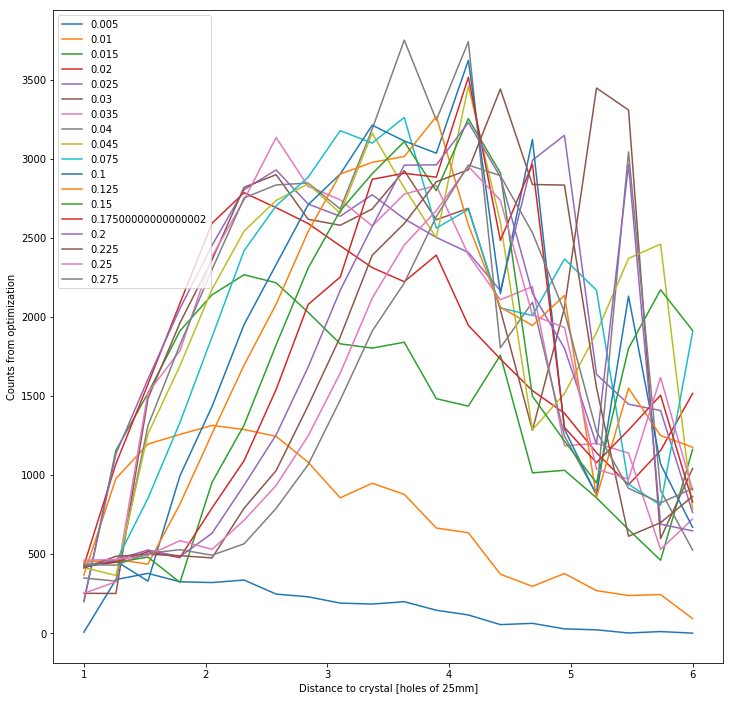

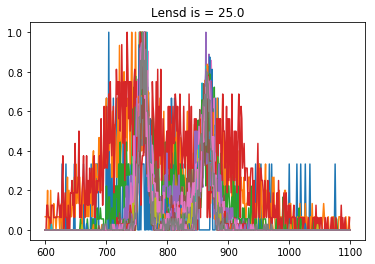

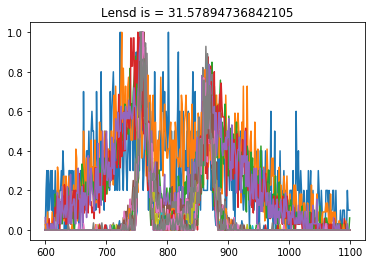

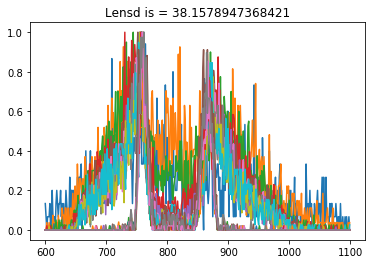

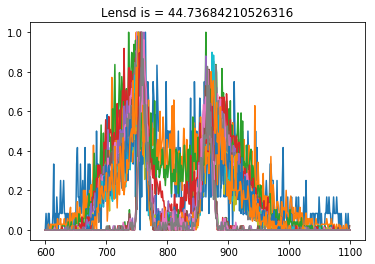

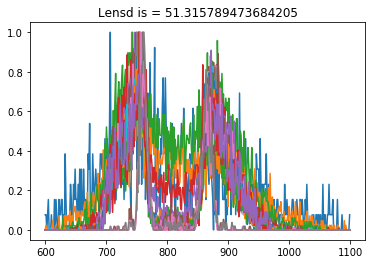

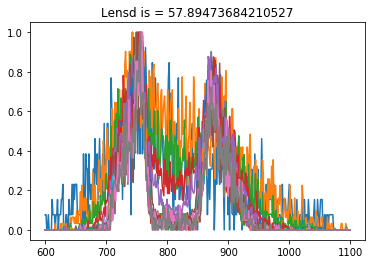

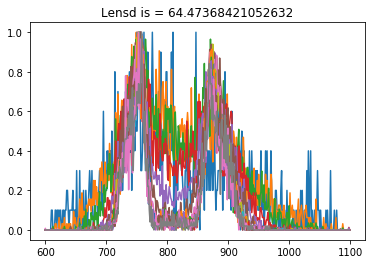

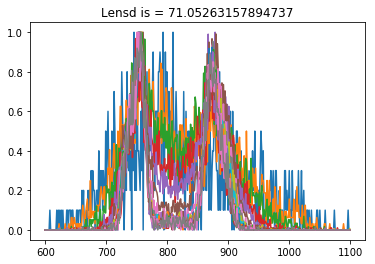

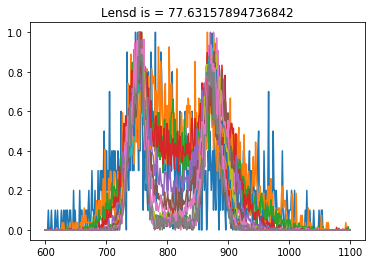

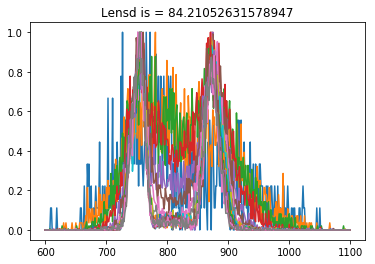

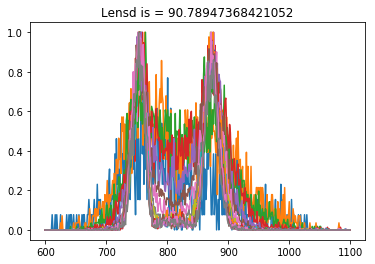

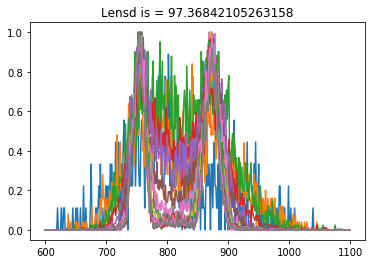

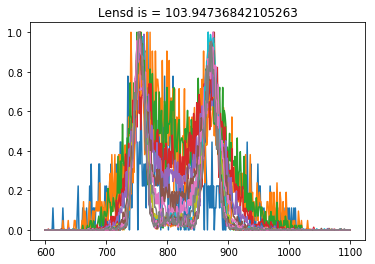

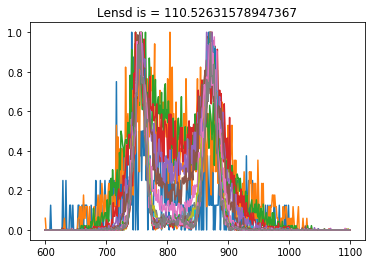

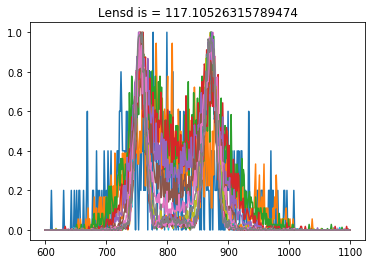

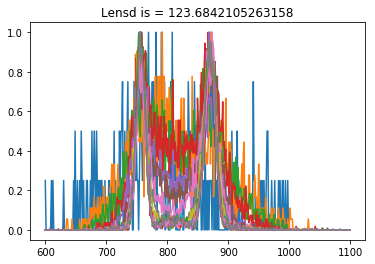

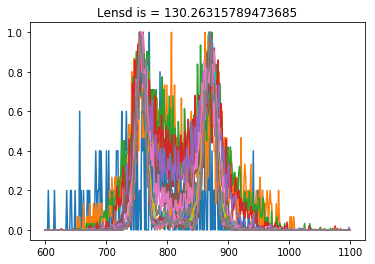

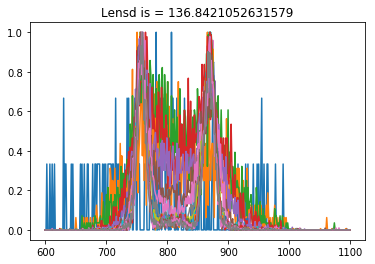

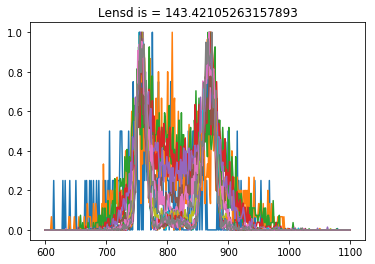

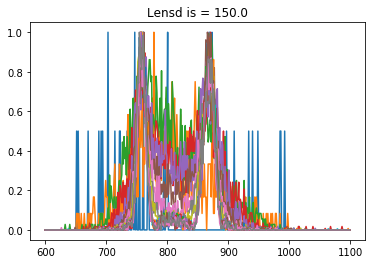

In [12]:

pumps = [[x*0.001,x*0.001] for x in range(5,50,5)] + [[x*0.001,x*0.001] for x in range(75,300,25)]


xpos=np.linspace(1,6,20)


plt.figure(figsize=[12,12])
for y,pump in enumerate(pumps):
#     c = ['r-','g-','b-','y-','k-','y-.','b-.','g-.','r-.'][y]
    label = pump[0]
    plt.plot(xpos,[max([(lensd_photons_1[y][i][0]) for kk in range(1)]) for i,x in enumerate(xpos)],label=label)

plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()


for x,x_pos in enumerate(xpos):
    plt.figure()
    [plt.plot(lensd_photons_1[y][x][3][1][0:-1],lensd_photons_1[y][x][3][0]/max(lensd_photons_1[y][x][3][0])) for y,j in enumerate(pumps)] 
    plt.title("Lensd is = {}".format(x_pos*25))
    plt.show()

C:\Users\ArianStolk\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


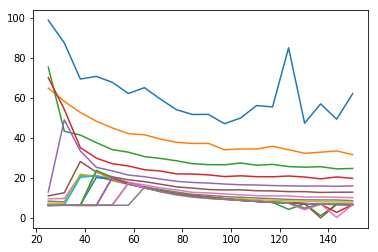

In [9]:
pumps = [[x*0.001,x*0.001] for x in range(5,50,5)] + [[x*0.001,x*0.001] for x in range(75,300,25)]

plt.figure()
fwhm=np.zeros((len(pumps),len(xpos)))
for y in range(len(pumps)):
    for x,x_pos in enumerate(xpos):
        ydata=lensd_photons_1[y][x][3][0][0:150]/max(lensd_photons_1[y][x][3][0])
        xdata=lensd_photons_1[y][x][3][1][0:150]
        p0 = [1.,780,10]
        coeff, var_matrix = scipy.optimize.curve_fit(gauss, xdata, ydata, p0=p0)                                             
        fwhm[y][x]=coeff[2]
plt.plot(np.tile(xpos*25,(fwhm.shape[0],1)).T,abs(fwhm).T)
plt.show()

In [72]:
fwhm

array([[  50.27743984,  120.41038334,   77.23785698,   70.67019756,
          69.3937969 ,   67.44293417,   60.67395149,   56.93665383,
          61.01529155,   50.78985086,   52.81668074,   50.57020994,
          48.58848352,   59.90026773,   75.23631756,   77.52011401,
          62.73382906,   59.2501457 ,   70.36456956,   83.34334867,
          68.34838336,   62.66866961,   64.5460037 ,   94.4525032 ,
          67.70478889],
       [  28.5415231 ,   62.08185378,   52.85177996,   48.40864099,
          47.44107035,   43.52329041,   43.28982397,   38.74321158,
          38.51582324,   38.289469  ,   35.16697678,   35.31951182,
          39.10041402,   36.18032169,   37.80848538,   32.42382932,
          40.37858838,   39.23913364,   31.22714359,   36.75831245,
          37.27573362,   33.13179616,   41.91293716,   38.13685552,
          36.12888329],
       [  18.55380367,   42.09260042,   40.61408492,   38.23642944,
          34.34452391,   32.92954366,   31.58550101,   30.37894773,


In [8]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [48]:
p0 = [1., 780, 10]

coeff, var_matrix = scipy.optimize.curve_fit(gauss, xdata, ydata, p0=p0)

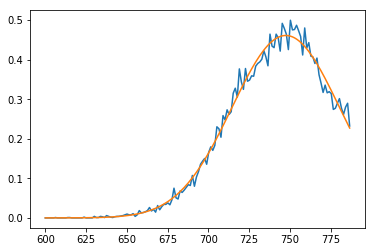

In [49]:
plt.plot(xdata,ydata)
plt.plot(xdata,gauss(xdata,*coeff))
plt.show()

In [45]:
rawdata=[[],[],[],[],[]]

pump_M2_list=np.array([[1.0577,1.1076],[1.22,1.08],[1.,1],[1.1,1.0]])*1
pumps = np.array([[0.098334,0.096517],[0.0521,0.096],[0.0325,0.0956],[0.099,0.1485]])
pump_focus_list=np.array([[2.5+11.9,2.5],[2.5,2.5+23],[2.5,2.5-10.5],[2.5,2.5-34.5]])

for y in [0,1,2,3]:

    rawdata[y+1]=[max([(lensd_photons_1[y][i][kk*4]) for kk in range(5)]) for i,x in enumerate(xpos)]
    
rawdata[0]=xpos
np.savez("C:/Users/ArianStolk/Documents/13012017_horizontal_ellipse",rawdata,pumps,pump_focus_list,pump_M2_list)

IndexError: list index out of range

In [2]:
imported=np.load("C:/Users/ArianStolk/Documents/22122017_vertical_ellipse.npz")

imported['arr_2']

NameError: name 'np' is not defined

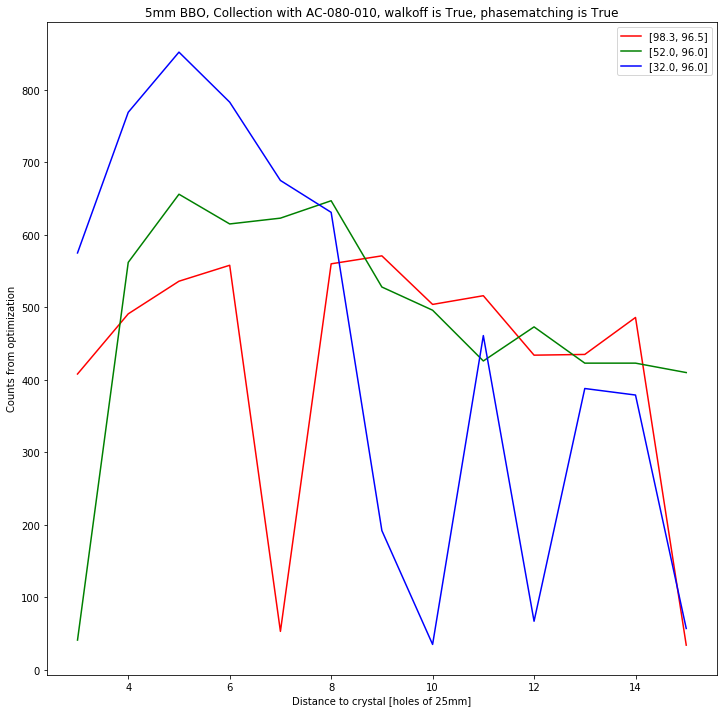

In [24]:
xpos=[3,4,5,6,7,8,9,10,11,12,13,14,15]
pumps = [[0.098334,0.096517],[0.052,0.096],[0.032,0.096]]
kk=0

plt.figure(figsize=[12,12])
for y in [0,1,2]:
    c = ['r-','g-','b-','y-','k-','y-.','b-.','g-.','r-.'][y]
    label = [1000*round(pumps[y][0],4),1000*round(pumps[y][1],4)]
    plt.plot(xpos,[(lensd_photons_2[y][i][kk*4]) for i,x in enumerate(xpos)],c,label=label)
plt.title("5mm BBO, Collection with AC-080-010, walkoff is {}, phasematching is {}".format([True,True,False,False][kk],[True,False,True,False][kk]))
plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()

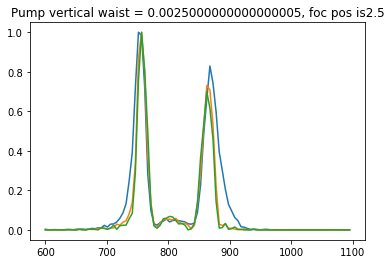

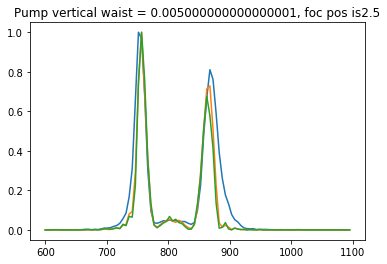

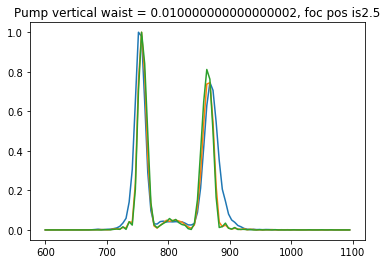

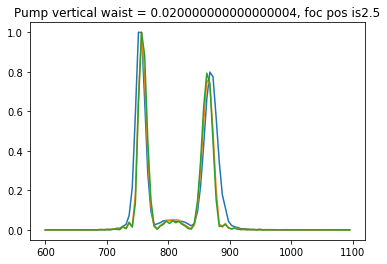

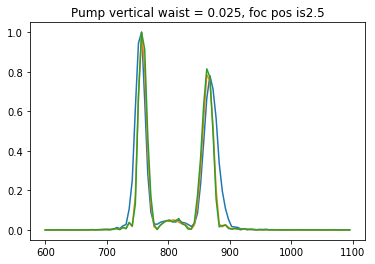

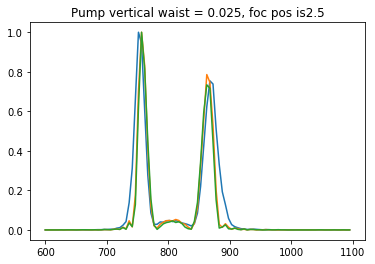

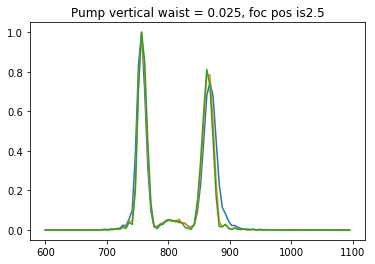

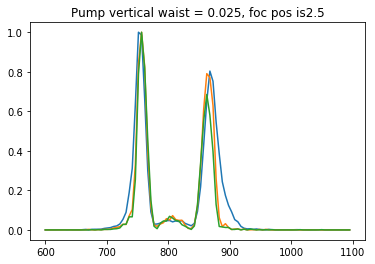

In [51]:
kk=12
for y in range(8):
    plt.figure()
    [plt.plot(lensd_photons_ast[y][x][3+kk][1][0:-1],lensd_photons_ast[y][x][3+kk][0]/max(lensd_photons_ast[y][x][3+kk][0])) for x in [0,5,-1]]
    plt.title("Pump vertical waist = {}, foc pos is{}".format(pumps[y][0],pump_focus_list[y][0]))
    plt.show()

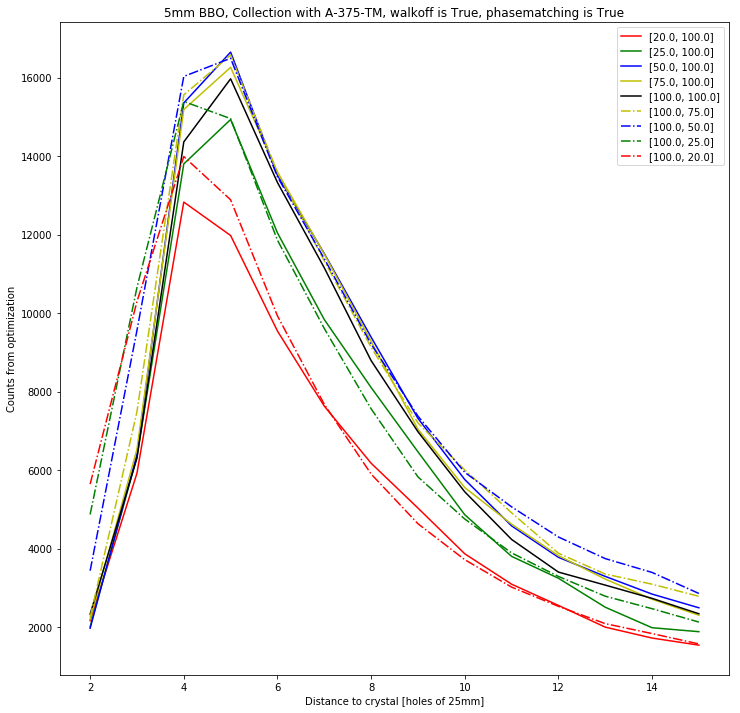

In [16]:
xpos=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]
kk=0

plt.figure(figsize=[12,12])
for y in [0,1,2,3,4,5,6,7,8]:
    c = ['r-','g-','b-','y-','k-','y-.','b-.','g-.','r-.'][y]
    label = [1000*round(pumps[y][0],4),1000*round(pumps[y][1],4)]
    plt.plot(xpos,[(lensd_photons_asph[y][i][kk*4]) for i,x in enumerate(xpos)],c,label=label)
plt.title("5mm BBO, Collection with A-375-TM, walkoff is {}, phasematching is {}".format([True,True,False,False][kk],[True,False,True,False][kk]))
plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()

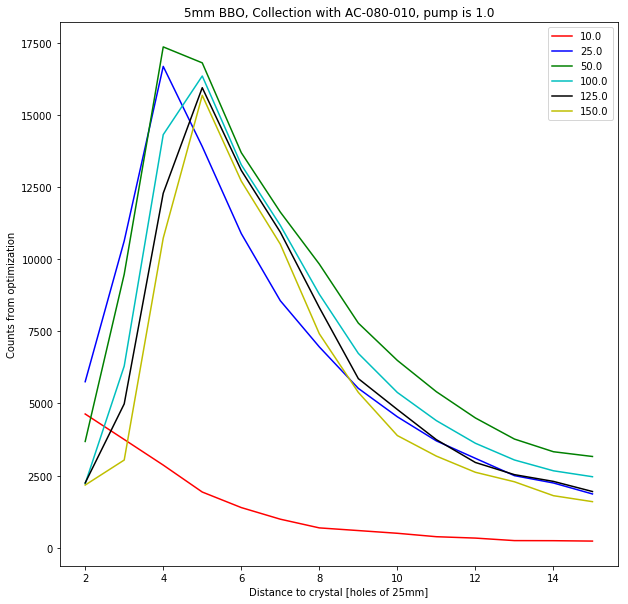

In [8]:
xpos=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]
kk=0

plt.figure(figsize=[10,10])
for y in [0,1,2,3,4,5]:
    c = ['r-','b-','g-','c-','k-','y-','m-'][y]
    label = 1000*round(pumps_circ[y][1],3)
    plt.plot(xpos,[(lensd_photons_circ_asph[y][i][kk]) for i,x in enumerate(xpos)],c,label=label)
plt.title("5mm BBO, Collection with A-375-TMB, pump is {}".format(pumps_circ[y][1]/pumps_circ[y][0]))
plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()

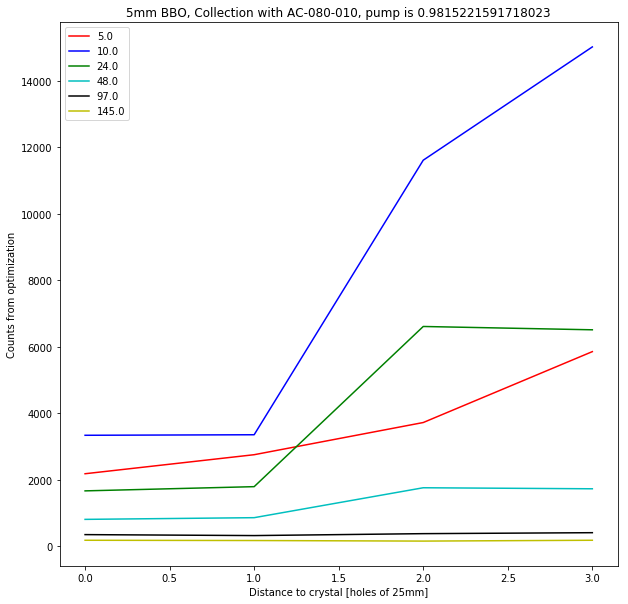

In [42]:
xpos=0
plt.figure(figsize=[10,10]) 
for y in [0,1,2,3,4,5]: 
    c = ['r-','b-','g-','c-','k-','y-','m-'][y] 
    label = 1000*round(pumps[y][1],3)
    plt.plot(range(4),[(lensd_photons[y][xpos][kk*4]) for kk in range(4)],c,label=label) 
    plt.title("5mm BBO, Collection with AC-080-010, pump is {}".format(pumps[y][1]/pumps[y][0])) 
    plt.xlabel("Distance to crystal [holes of 25mm]") 
    plt.ylabel("Counts from optimization") 
plt.legend() 
plt.show()

In [55]:
np.savez("C:/Users/ArianStolk/Documents/ast_sweep_10122017_result_circsym_sweep",lensd_photons)
# np.savez("C:/Users/ArianStolk/Documents/ast_sweep_10122017_coos_circsym_sweep",np.reshape(lensd_fibre,(6,len([4,5,6,7,8,9,10,11,12,13,14,15]),3)))
# np.savez("C:/Users/ArianStolk/Documents/ast_sweep_10122017_pumps_circsym_sweep",np.reshape(pumps,(6,2)))

ValueError: setting an array element with a sequence.

In [60]:
lensd_photons[0][0]

[2175,
 0.5867278122471001,
 0.7430816535702084,
 (array([  3,   3,   0,   0,   2,   2,   1,   0,   3,   4,   4,   4,   5,
          15,   6,  13,  20,  17,  20,  28,  32,  45,  55,  53,  88,  79,
         106, 119, 155, 167, 191, 212, 197, 175, 167, 150, 146, 139, 144,
         129, 136, 142, 132, 120, 128, 150, 123, 140, 148, 154, 160, 162,
         181, 188, 199, 175, 154, 151, 119, 124, 107,  87,  64,  80,  47,
          58,  47,  50,  42,  47,  37,  30,  26,  17,  20,  20,  21,  21,
           9,  19,  11,   6,   8,  11,   7,  10,   2,   4,  10,   3,   2,
           5,   3,   1,   0,   2,   1,   2,   0], dtype=int64),
  array([  600.        ,   605.05050505,   610.1010101 ,   615.15151515,
           620.2020202 ,   625.25252525,   630.3030303 ,   635.35353535,
           640.4040404 ,   645.45454545,   650.50505051,   655.55555556,
           660.60606061,   665.65656566,   670.70707071,   675.75757576,
           680.80808081,   685.85858586,   690.90909091,   695.95959596,
    

get_counts_evol([-0.6,0,151],0.1,0.22)

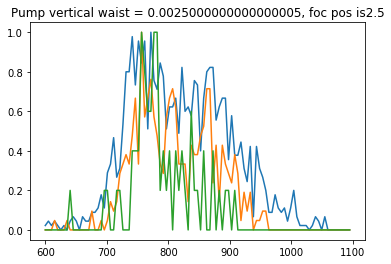

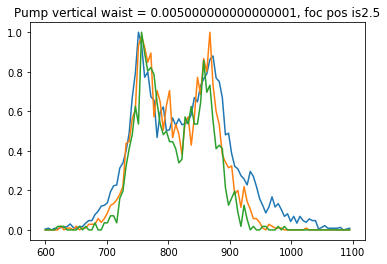

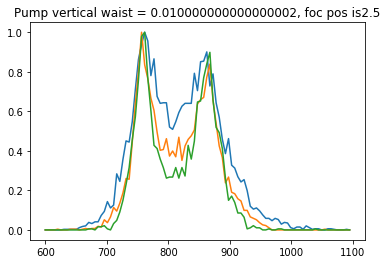

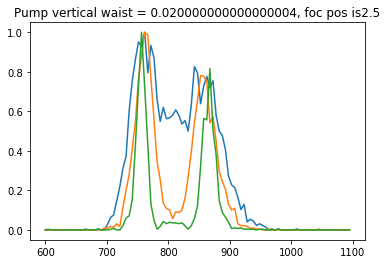

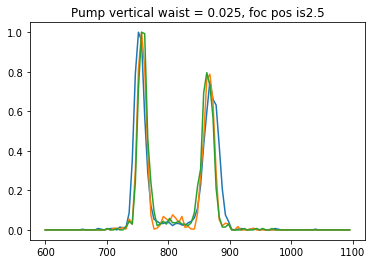

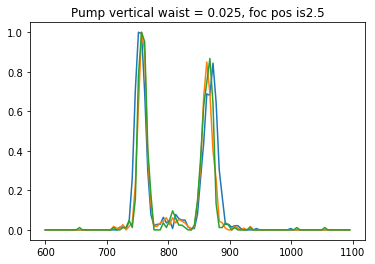

In [42]:
kk=0
for y in range(6):
    plt.figure()
    [plt.plot(lensd_photons[y][x][3+kk][1][0:-1],lensd_photons[y][x][3+kk][0]/max(lensd_photons[y][x][3+kk][0])) for x in [0,5,-1]]
    plt.title("Pump vertical waist = {}, foc pos is{}".format(pumps[y][0],pump_focus_list[y][0]))
    plt.show()

In [43]:
sum([lensd_photons[1][1][3+z][0] for z in [0,4,8]])

array([   0,    0,    0,    0,    1,    1,    0,    0,    0,    0,    1,
          0,    2,    1,    3,    7,    5,    4,    7,   15,   27,   23,
         95,  235,  489,  764,  944, 1121, 1275, 1624, 2091, 1969, 1291,
        701,  274,  105,   87,   88,  114,   90,  114,  109,   94,   91,
        106,   81,   72,   79,  109,  229,  528,  864, 1292, 1559, 1483,
       1230, 1007,  824,  783,  621,  587,  508,  443,  427,  316,  185,
         86,   59,   40,   25,   20,   10,   10,    3,    8,    4,    3,
          1,    2,    1,    4,    3,    2,    0,    4,    1,    0,    0,
          1,    0,    0,    1,    0,    0,    0,    0,    0,    0,    0], dtype=int64)

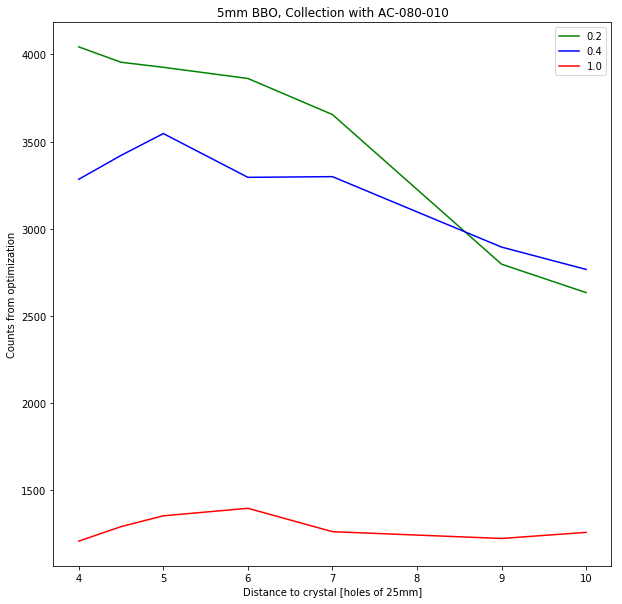

In [43]:
pumps = np.array([[121,28],[119,43],[120,79],[117,117],[78,116],[43,119],[28,121]])/1000
xpos=[4,4.5,5,6,7,9,10]

plt.figure(figsize=[10,10])
for y in [0,1,3]:
    c = ['g-','b-','b-','r-','k-','c-.','b-.','g-.'][y]
    label = [round(pump[1]/pump[0],1) for pump in pumps][y]
    plt.plot(xpos,[result_achromat[0][y][i+4] for i,x in enumerate(xpos)],c,label=label)

plt.title("5mm BBO, Collection with AC-080-010")
plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()

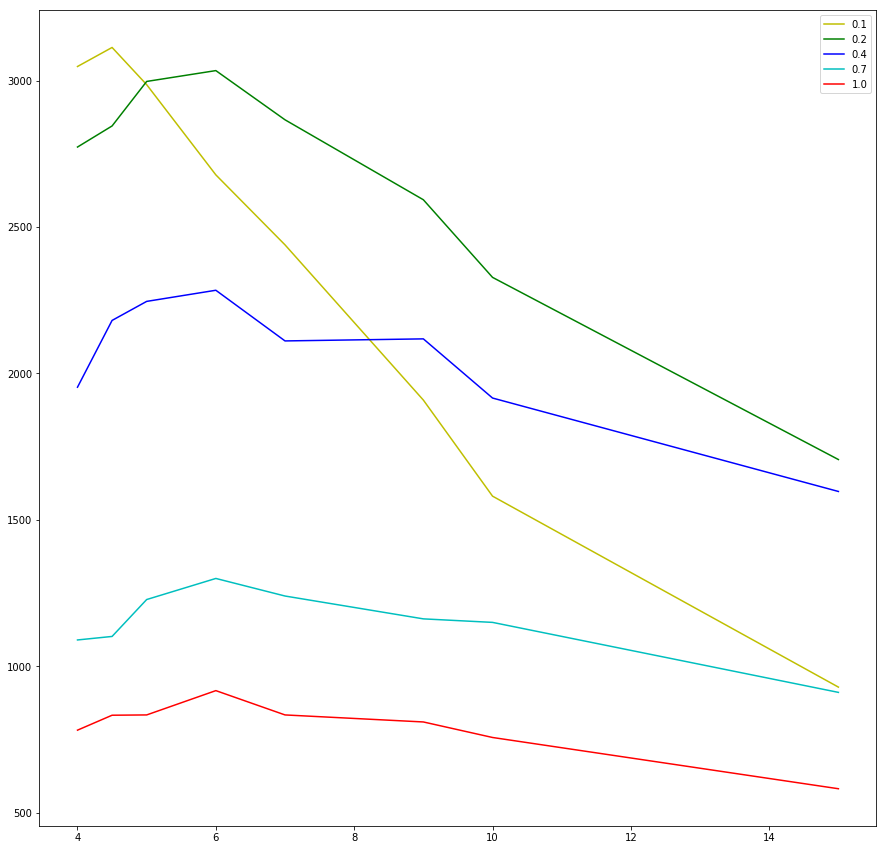

In [30]:
imported_data=np.load("C:/Users/ArianStolk/Documents/ast_sweep_28112017.npz")['arr_0']

plt.figure(figsize=[15,15])
for y in range(5):
    c = ['y-','g-','b-','c-','r-','c-.','b-.','g-.'][y]
    label = [round(pump[1]/pump[0],1) for pump in pumps][y]
    xpos=[4,4.5,5,6,7,9,10,15]
    plt.plot(xpos,[imported_data[0][y][i+4] for i,x in enumerate(xpos)],c,label=label)

plt.legend()
plt.show()

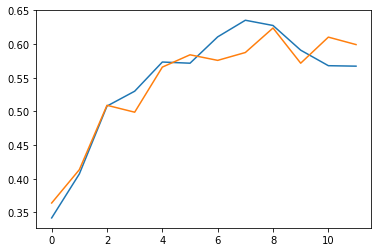

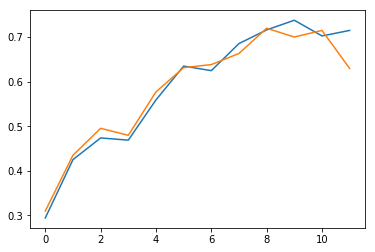

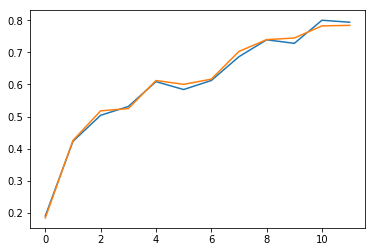

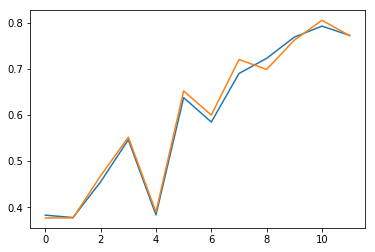

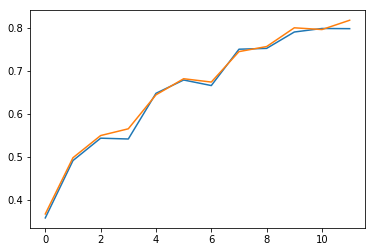

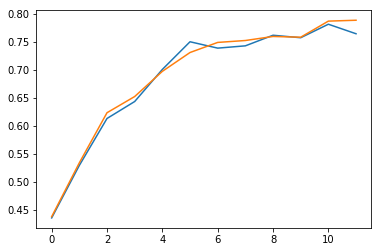

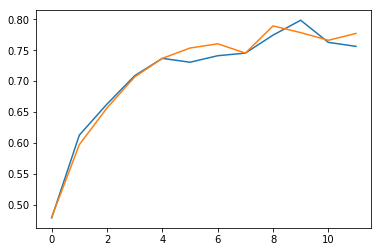

IndexError: list index out of range

In [38]:

for y in range(8):
    plt.figure()
    plt.plot([lensd_photons[y][x][1:3] for x in range(len([2,2.5,3,3.5,4,4.5,5,6,7,9,10,15]))])
    plt.show()


In [118]:
N=10000
M=50

send=np.float32(vis2.complete_results[0][0][...,-1][0:N][...,0:2])
sbeg=np.float32(vis2.complete_results[0][0][...,-2][0:N][...,0:2])

iend=np.float32(vis2.complete_results[1][0][...,-1][0:N][...,0:2])
ibeg=np.float32(vis2.complete_results[1][0][...,-2][0:N][...,0:2])

x,y,z=np.full(M,-0.2,dtype=np.float32),np.full(M,0,dtype=np.float32),np.full(M,61.375+25.,dtype=np.float32)

res=np.empty((M,M,M),dtype=np.float32)

In [119]:

cProfile.run('res=d_coinc(sbeg,send,ibeg,iend,x,y,z)',sort="time")

         3 function calls in 3.869 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    3.869    3.869    3.869    3.869 <string>:1(<module>)
        1    0.000    0.000    3.869    3.869 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




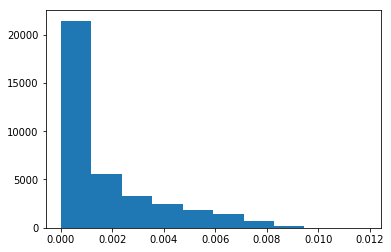

(array([    0,     1,     2, ..., 36958, 36959, 36960], dtype=int64),)

In [59]:
((vis2.complete_results[0][0][...,1][...,0:2]-np.array([-0.16,0]))*(vis2.complete_results[0][0][...,1][...,0:2]-np.array([-0.16,0]))).sum(axis=1)<4*4

array([False, False, False, ..., False,  True,  True], dtype=bool)

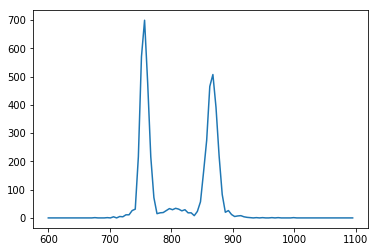

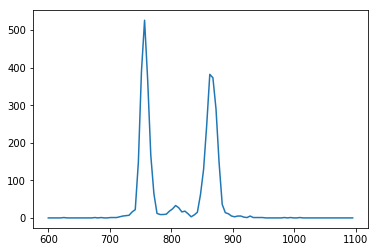

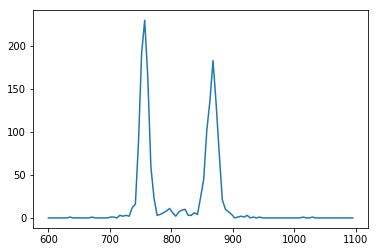

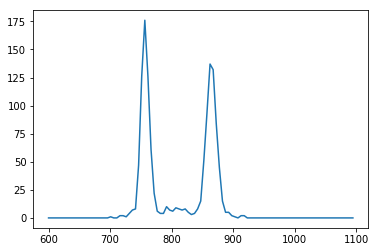

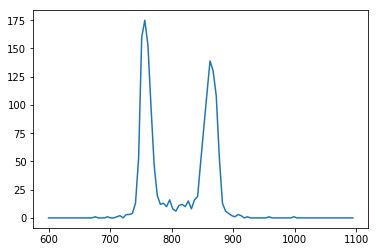

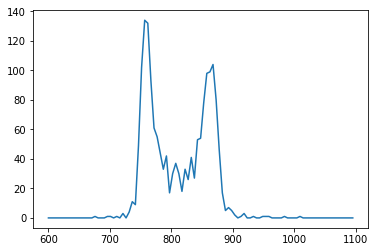

In [48]:
y=0
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=1
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=2
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=3
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=4
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=5
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()

In [34]:
[sum([lensd_photons[0][0][x] for x in [0,4,8,12,16]])

13326

In [37]:
[sum([lensd_photons[y][i][z] for z in [0,4,8,12,16]]) for i,x in enumerate(xpos)]

[13326, 14280, 14146, 14548, 14016, 13037, 12333, 11295, 10658, 7439]

In [16]:
vars(cuda.gpus[0])

{'_device': <weakproxy at 0x0000025C5E5C8958 to Device at 0x0000025C5E4E2198>}

In [31]:
cuda.list_devices().current

In [31]:
0.1/(sqrt(2*log(2)))

0.08493218002880192

1


TypeError: list indices must be integers or slices, not tuple

In [46]:
randomnrs= pcl.rand.normal(0.,1/sqrt(2),1000000,dtype=np.float32, device=False)
np.std(randomnrs)

0.70658433

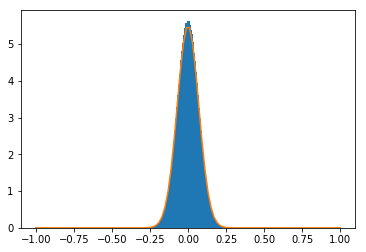

In [47]:
plt.figure()
plt.hist(randomnrs*0.1,100,density=True)
plt.plot(np.linspace(-1,1,100),[exp(-(x**2)/(0.1**2))*5.5 for x in np.linspace(-1,1,100)])
plt.show()

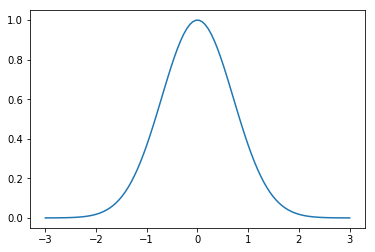

In [34]:
plt.figure()
plt.plot(np.linspace(-3,3,100),[exp(-(x**2)/(1**2)) for x in np.linspace(-3,3,100)])
plt.show()

In [77]:
[[2.5-22.8,2.5]]*5

[[-20.3, 2.5], [-20.3, 2.5], [-20.3, 2.5], [-20.3, 2.5], [-20.3, 2.5]]

In [43]:
import sys


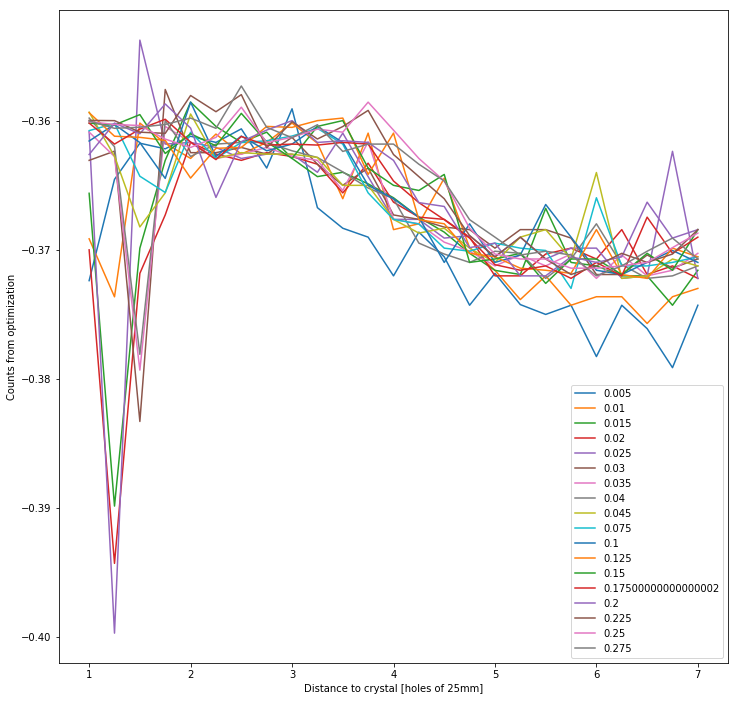

In [23]:
plt.figure(figsize=[12,12])
for y,pump in enumerate(pumps):
#     c = ['r-','g-','b-','y-','k-','y-.','b-.','g-.','r-.'][y]
    label = pump[0]
    plt.plot(xpos,[(lensd_fibre_1[y][i][0]-0.18) for i,x in enumerate(xpos)],label=label)

plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()


[[[-0.19238658, -0.012216143, 35.823341],
  [-0.18453965, 0.0055310186, 42.353439],
  [-0.18173993, 0.0011624397, 48.731655],
  [-0.18217488, 0.0029015094, 54.458508],
  [-0.18119785, -0.00055183168, 60.384483],
  [-0.18167861, -0.00023959417, 66.359177],
  [-0.18062772, -0.0017358456, 72.473259],
  [-0.18366475, -9.3945033e-05, 78.543571],
  [-0.17907324, 0.0018266693, 84.712631],
  [-0.18673335, -0.002410731, 90.834969],
  [-0.18832673, 0.0013473794, 97.003899],
  [-0.18901703, 0.00076436426, 103.20519],
  [-0.19201699, -0.0030915625, 109.37914],
  [-0.18862836, -0.0021641213, 115.58251],
  [-0.19054171, -0.00028280998, 121.79907],
  [-0.19429305, -0.00016331964, 128.01286],
  [-0.19182265, -0.0026485501, 134.21907],
  [-0.19424127, -0.00089950464, 140.44052],
  [-0.19500417, -0.0010771338, 146.64902],
  [-0.19429305, -0.0027982336, 152.88217],
  [-0.19826891, -0.0041771927, 159.09283],
  [-0.19429305, 0.0049308296, 165.35158],
  [-0.1961039, -0.003772289, 171.55565],
  [-0.19912761,

In [27]:
np.meshgrid(np.linspace(-0.4,-0.0,100),np.linspace(-0.1,0.1,50))[1].shape

(50, 100)

In [28]:
np.unravel_index(119,[50,100])

(1, 19)